# Feature Expansion, or: Feature Engineering III

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [2]:
data = datasets.load_diabetes()

In [3]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [4]:
data

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990842, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06832974, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286377, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04687948,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452837, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00421986,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [5]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [6]:
y

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Length: 442, dtype: float64

In [7]:
# For us to practice: Adds categorical data with some nan as new column
X['diet'] = random.choices(['with meat', 'pescetarian', 'vegetarian', 'vegan'], k=X.shape[0])
to_nan = X.sample(50, random_state=42).index
X.loc[to_nan, 'diet'] = np.NaN

In [8]:
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,diet
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,with meat
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,vegetarian
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,pescetarian
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,vegetarian
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,vegan
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,vegan
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,pescetarian
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,pescetarian
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,vegetarian


### Train test split

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [10]:
xtrain.shape, ytrain.shape

((331, 11), (331,))

# Feature Engineering methods

### Handling Missing Values

<AxesSubplot:>

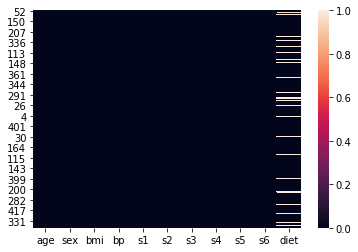

In [11]:
sns.heatmap(xtrain.isna())

In [12]:
xtrain.isna().sum()

age      0
sex      0
bmi      0
bp       0
s1       0
s2       0
s3       0
s4       0
s5       0
s6       0
diet    33
dtype: int64

### How can we fill the missing values? 
- mean, average, specific value, also per group
- SimpleImputer (IterativeImputer)

In [13]:
SimpleImputer(strategy='most_frequent')

SimpleImputer(strategy='most_frequent')

In [14]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))  #two things we need in here: (name, transformer)
])    #make_pipeline

In [ ]:
# If we had to scale, how would we do it? MinMaxScaler, StandardScaler

### Handling categorical data

In [15]:
# One hot encoding
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),#two things we need in here: (name, transformer)
    ('one_hot_encoder', OneHotEncoder(sparse=False))  # dense
]) 

### Binning

In [16]:
binning_pipline = Pipeline([
    ('binning', KBinsDiscretizer(encode='ordinal'))
])

### Interaction Terms

In [17]:
interaction_pipeline = Pipeline([
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False, ))
])

In [18]:
pd.DataFrame(interaction_pipeline.fit_transform(xtrain[['bmi', 'sex']]), columns=['bmi', 'sex', 'interaction_term'] )

,bmi,sex,interaction_term
0,-0.009439,-0.044642,0.000421
1,-0.051474,-0.044642,0.002298
2,0.031517,-0.044642,-0.001407
3,0.001339,0.050680,0.000068
4,-0.021295,0.050680,-0.001079
...,...,...,...
326,-0.054707,-0.044642,0.002442
327,0.060618,-0.044642,-0.002706
328,-0.022373,0.050680,-0.001134
329,-0.032073,-0.044642,0.001432


In [19]:
xtrain['bmi'] * xtrain['sex']

52     0.000421
1      0.002298
217   -0.001407
389    0.000068
132   -0.001079
         ...   
419    0.002442
249   -0.002706
284   -0.001134
246    0.001432
62    -0.000369
Length: 331, dtype: float64

### How it all comes together: Colum Transformer

In [20]:
column_transform = ColumnTransformer([
    ('transform_diet', cat_pipeline, ['diet']),
    ('binning_age', binning_pipline, ['age']),
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False), ['bmi', 'sex']) #'remainder='passthrough
])

In [21]:
# Fit the ColumnTransformer, Transform
column_transform.fit_transform(xtrain)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.43939036e-03, -4.46416365e-02,  4.21389833e-04],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -5.14740612e-02, -4.46416365e-02,  2.29788633e-03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         3.15174685e-02, -4.46416365e-02, -1.40699137e-03],
       ...,
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.23731352e-02,  5.06801187e-02, -1.13387315e-03],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.20734439e-02, -4.46416365e-02,  1.43181102e-03],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.28376621e-03,  5.06801187e-02, -3.69142136e-04]])

In [22]:
xtrain_fe = pd.DataFrame(column_transform.fit_transform(xtrain), columns=['diet1', 'diet2', 'diet3', 'diet4', 'age', 'bmi', 'sex', 'interaction_bmi_sex'])

In [33]:
xtrain_fe

,diet1,diet2,diet3,diet4,age,bmi,sex,interaction_bmi_sex
0,0.0,0.0,1.0,0.0,4.0,-0.043929,0.050680,-0.002226
1,0.0,0.0,1.0,0.0,3.0,-0.046085,-0.044642,0.002057
2,0.0,1.0,0.0,0.0,4.0,-0.008362,-0.044642,0.000373
3,0.0,0.0,1.0,0.0,4.0,-0.006206,0.050680,-0.000315
4,0.0,0.0,0.0,1.0,2.0,-0.008362,0.050680,-0.000424
...,...,...,...,...,...,...,...,...
326,0.0,0.0,0.0,1.0,3.0,-0.023451,-0.044642,0.001047
327,1.0,0.0,0.0,0.0,3.0,-0.001895,0.050680,-0.000096
328,0.0,0.0,0.0,1.0,0.0,-0.089197,0.050680,-0.004521
329,1.0,0.0,0.0,0.0,4.0,-0.008362,0.050680,-0.000424


In [23]:
xtest_fe = column_transform.transform(xtest)  # also for all new unseen data

In [24]:
all_pipe = Pipeline([
    ('column_transformer', column_transform),   
    ('regression', LinearRegression())
])

## Feature Selection
Not all features in your data might be required for a good model. To reduce overfitting (and speed up your model), we can reduce the features we use to train our model.

### 1. Option: Remove highly correlated features 

<AxesSubplot:>

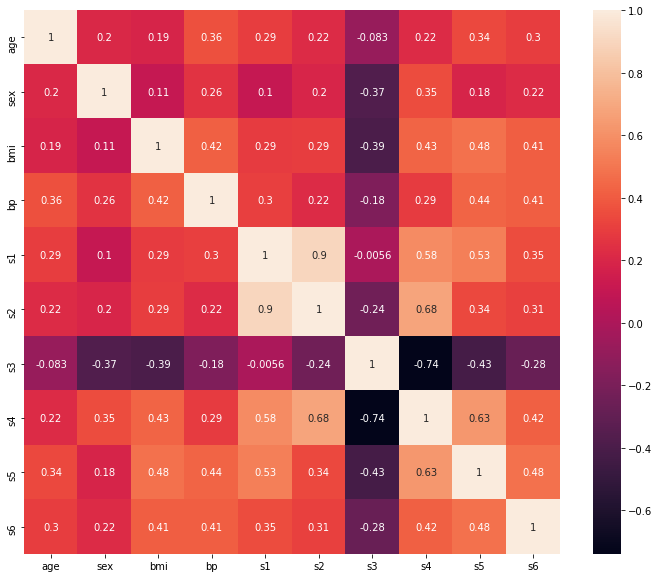

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(xtrain.corr(), annot=True)

### 2. Option: For Random Forest Regressor/Classifier: examine the feature_importance values in the trained model.

In [26]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(xtrain_fe, ytrain)

RandomForestRegressor()

In [27]:
rf.feature_importances_  # the higher the values the more important

array([0.03100805, 0.02189863, 0.02828147, 0.02843306, 0.12289711,
       0.55755431, 0.01169013, 0.19823725])

In [28]:
xtrain_fe.columns

Index(['diet1', 'diet2', 'diet3', 'diet4', 'age', 'bmi', 'sex',
       'interaction_bmi_sex'],
      dtype='object')

### 3. RFE: Recursive Feature Elimination
Trains the model multiple times, eliminating different features in each run. In scikit the RFE class can be used to optimize an existing model

In [29]:
rfe = RFE(rf)
rfe.fit(xtrain_fe, ytrain)

RFE(estimator=RandomForestRegressor())

In [30]:
rfe.support_ 

array([ True, False, False, False,  True,  True, False,  True])

In [31]:
rfe.ranking_   # 1 is most important

array([1, 4, 2, 3, 1, 1, 5, 1])

In [ ]:
# 4. Option: statsmodels -> p-values 

In [ ]:
# 5. Option: Regularization Techniques -> Lasso, ElasticNet

In [ ]:
# 6. OPtion: PCA (in a later week)

## Polynomial Features

In [32]:
x_p = pd.DataFrame([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y_p = [9.01, 7.90, 8.74, 8.97, 9.46, 8.24, 6.53, 3.10, 9.13, 7.26, 4.84]

<AxesSubplot:xlabel='0'>

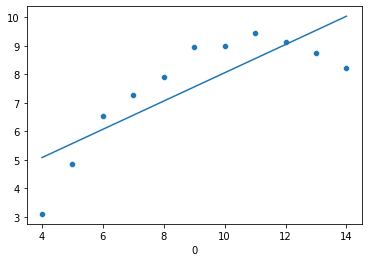

In [35]:
sns.scatterplot(x=x_p[0], y=y_p)
sns.lineplot(x=x_p[0], y=ypred)

In [34]:
lr = LinearRegression()
lr.fit(x_p, y_p)
ypred =lr.predict(x_p)

In [36]:
x_p['square'] = x_p[0]**2

In [37]:
x_p

,0,square
0,10,100
1,8,64
2,13,169
3,9,81
4,11,121
5,14,196
6,6,36
7,4,16
8,12,144
9,7,49


In [38]:
lr2 = LinearRegression()
lr2.fit(x_p, y_p)
ypred2 = lr2.predict(x_p)

<AxesSubplot:xlabel='0'>

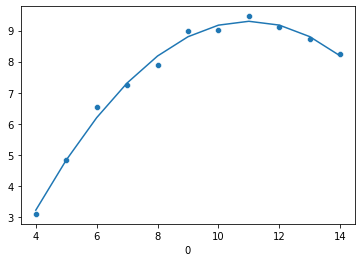

In [39]:
sns.scatterplot(x=x_p[0], y=y_p)
sns.lineplot(x=x_p[0], y=ypred2)

In [41]:
# In a pipeline:
poly_pipline = Pipeline([
    ('poly_terms', PolynomialFeatures(degree=2))
])

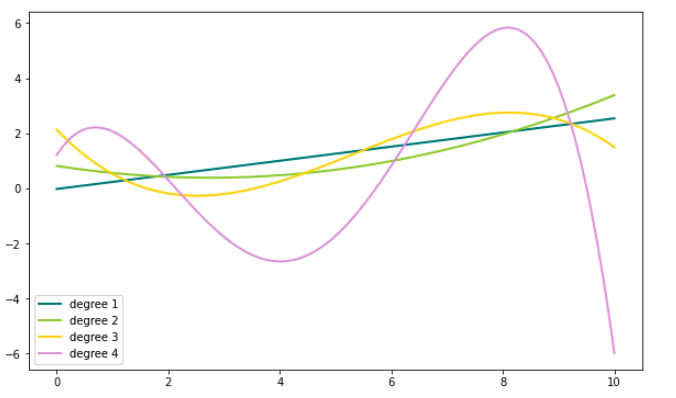

In [42]:
from IPython.display import Image
Image("degrees.png")